In [26]:
!pip install tensorflow opencv-python


In [27]:
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    Input,
    Flatten,
    Dropout,
    MaxPooling2D,
    BatchNormalization,
    GlobalAveragePooling2D,
    LayerNormalization,
    Embedding,
    MultiHeadAttention,
    UpSampling2D
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [30]:
dataset_path = "/content/drive/MyDrive/MRIDataset"

train_path = os.path.join(dataset_path, "Training")
test_path = os.path.join(dataset_path, "Testing")

width, height = 224, 224
batch_size = 32

In [31]:
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_dataset = train_datagen.flow_from_directory(
    train_path,
    target_size=(width, height),
    batch_size=batch_size,
    class_mode="categorical"
)

test_dataset = test_datagen.flow_from_directory(
    test_path,
    target_size=(width, height),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


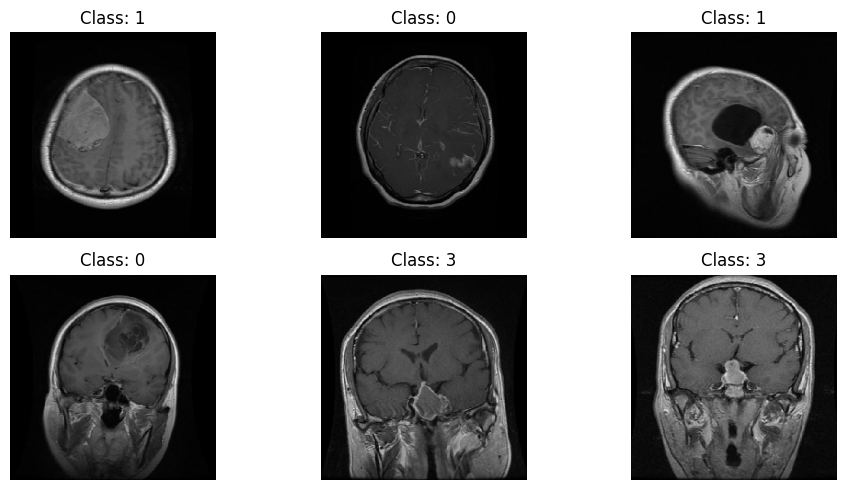

In [32]:
x_batch, y_batch = next(train_dataset)

plt.figure(figsize=(10, 5))

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_batch[i])  # Display the i-th image.
    plt.title(f"Class: {np.argmax(y_batch[i])}")
    plt.axis("off")  # Hide the axis ticks.

plt.tight_layout()
plt.show()


In [33]:
class PatchExtractor(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(PatchExtractor, self).__init__()
        self.patch_size = patch_size
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [34]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = Dense(units=projection_dim)
        self.position_embedding = Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded

In [35]:
def transformer_block(inputs, num_heads, projection_dim, dropout_rate=0.1):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x, x)
    x = tf.keras.layers.Add()([attention_output, inputs])

    x1 = LayerNormalization(epsilon=1e-6)(x)
    x1 = Dense(units=projection_dim * 2, activation='relu')(x1)
    x1 = Dense(units=projection_dim)(x1)
    x = tf.keras.layers.Add()([x, x1])
    return x

In [36]:
def build_vit_classifier(input_shape=(width, height, 3), patch_size=32,
                         num_layers=8, num_heads=4, projection_dim=64,
                         mlp_head_units=[128]):
    inputs = Input(shape=input_shape)

    patch_extractor = PatchExtractor(patch_size)
    patches = patch_extractor(inputs)

    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)

    patch_encoder = PatchEncoder(num_patches, projection_dim)
    encoded_patches = patch_encoder(patches)

    for _ in range(num_layers):
        encoded_patches = transformer_block(encoded_patches, num_heads, projection_dim)

    representation = LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = Flatten()(representation)

    for units in mlp_head_units:
        representation = Dense(units, activation='relu')(representation)
        representation = Dropout(0.1)(representation)

    outputs = Dense(4, activation='softmax')(representation)

    model = Model(inputs=inputs, outputs=outputs, name="ViT_Classifier")
    return model

In [37]:
def build_efficientnet_classifier(input_shape=(width, height, 3), num_classes=4):
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        input_shape=input_shape,
        weights='imagenet'
    )
    base_model.trainable = True

    for layer in base_model.layers[:-20]:
        layer.trainable = False

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=True)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs, name="EfficientNet_Classifier")
    return model

In [38]:
import cv2
from skimage.filters import threshold_otsu
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
def create_segmentation_mask(image):
    image_uint8 = (image * 255).astype(np.uint8)
    if image_uint8.shape[-1] == 3:
        gray = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2GRAY)
    else:
        gray = image_uint8
    thresh = threshold_otsu(gray)
    mask = gray > thresh
    return mask.astype(np.float32)

def segmentation_generator(image_generator):
    while True:
        images, _ = next(image_generator)
        masks = np.array([create_segmentation_mask(img) for img in images])
        masks = np.expand_dims(masks, axis=-1)
        yield images, masks

In [39]:
def build_unet_model(input_shape=(224, 224, 3)):
    inputs = Input(shape=input_shape)

    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)

    u4 = UpSampling2D((2, 2))(c3)
    u4 = Conv2D(32, (2, 2), activation='relu', padding='same')(u4)
    m4 = Concatenate()([u4, c2])
    c4 = Conv2D(32, (3, 3), activation='relu', padding='same')(m4)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(32, (3, 3), activation='relu', padding='same')(c4)

    u5 = UpSampling2D((2, 2))(c4)
    u5 = Conv2D(16, (2, 2), activation='relu', padding='same')(u5)
    m5 = Concatenate()([u5, c1])
    c5 = Conv2D(16, (3, 3), activation='relu', padding='same')(m5)
    c5 = Dropout(0.1)(c5)
    c5 = Conv2D(16, (3, 3), activation='relu', padding='same')(c5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs=inputs, outputs=outputs, name="Fast_U_Net")
    return model

In [40]:
vit_model = build_vit_classifier()

eff_model = build_efficientnet_classifier()

unet_model = build_unet_model()

In [41]:
vit_model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [42]:
eff_model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [43]:
unet_model = build_unet_model()

unet_model.summary()

Model: "Fast_U_Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 224, 224,  │        448 │ input_layer_9[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 224, 224,  │          0 │ conv2d_39[0][0]   │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 224, 224,  │      2,320 │ dropout_35[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 112, 112,  │          0 │ conv2d_40[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 112, 112,  │      4,640 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 112, 112,  │          0 │ conv2d_41[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 112, 112,  │      9,248 │ dropout_36[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 56, 56,    │          0 │ conv2d_42[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 56, 56,    │     18,496 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 56, 56,    │          0 │ conv2d_43[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 56, 56,    │     36,928 │ dropout_37[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_6     │ (None, 112, 112,  │          0 │ conv2d_44[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 112, 112,  │      8,224 │ up_sampling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 112, 112,  │          0 │ conv2d_45[0][0],  │
│ (Concatenate)       │ 64)               │            │ conv2d_42[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 112, 112,  │     18,464 │ concatenate_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 112, 112,  │          0 │ conv2d_46[0][0] 

 Total params: 117,041 (457.19 KB)

 Trainable params: 117,041 (457.19 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, restore_best_weights=True)

In [45]:
history_vit = vit_model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    callbacks=[earlyStopping]
)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 65s 209ms/step - accuracy: 0.5978 - loss: 1.0044 - val_accuracy: 0.7658 - val_loss: 0.5740
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 27s 149ms/step - accuracy: 0.8349 - loss: 0.4585 - val_accuracy: 0.8223 - val_loss: 0.4484
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 143ms/step - accuracy: 0.8842 - loss: 0.3220 - val_accuracy: 0.8337 - val_loss: 0.4111
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 143ms/step - accuracy: 0.9079 - loss: 0.2489 - val_accuracy: 0.8886 - val_loss: 0.2964
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 142ms/step - accuracy: 0.9398 - loss: 0.1708 - val_accuracy: 0.8986 - val_loss: 0.2545
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 144ms/step - accuracy: 0.9479 - loss: 0.1493 - val_accuracy: 0.9100 - val_loss: 0.2246
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 145ms/step - accuracy: 0.9609 - loss: 0.1170 - val_accuracy: 0.9352 - val_loss: 0.1977
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 143ms/step - accuracy: 0.9732 - loss: 0

In [51]:
history_eff = eff_model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 147ms/step - accuracy: 0.4841 - loss: 1.1512 - val_accuracy: 0.5667 - val_loss: 1.1652
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 145ms/step - accuracy: 0.5015 - loss: 1.1268 - val_accuracy: 0.4142 - val_loss: 1.2604
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 143ms/step - accuracy: 0.5169 - loss: 1.1099 - val_accuracy: 0.3135 - val_loss: 1.5623
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 142ms/step - accuracy: 0.5385 - loss: 1.0693 - val_accuracy: 0.3936 - val_loss: 1.4917
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 145ms/step - accuracy: 0.5512 - loss: 1.0527 - val_accuracy: 0.3105 - val_loss: 2.4697
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 25s 140ms/step - accuracy: 0.5606 - loss: 1.0199 - val_accuracy: 0.4470 - val_loss: 1.3440
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 146ms/step - accuracy: 0.5622 - loss: 1.0286 - val_accuracy: 0.5202 - val_loss: 1.1157
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 147ms/step - accuracy: 0.5634 - loss: 1

100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 317ms/step - accuracy: 0.9505 - loss: 0.1250 - val_accuracy: 0.9500 - val_loss: 0.1384
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 312ms/step - accuracy: 0.9521 - loss: 0.1240 - val_accuracy: 0.9503 - val_loss: 0.1391
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 311ms/step - accuracy: 0.9528 - loss: 0.1217 - val_accuracy: 0.9528 - val_loss: 0.1321
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


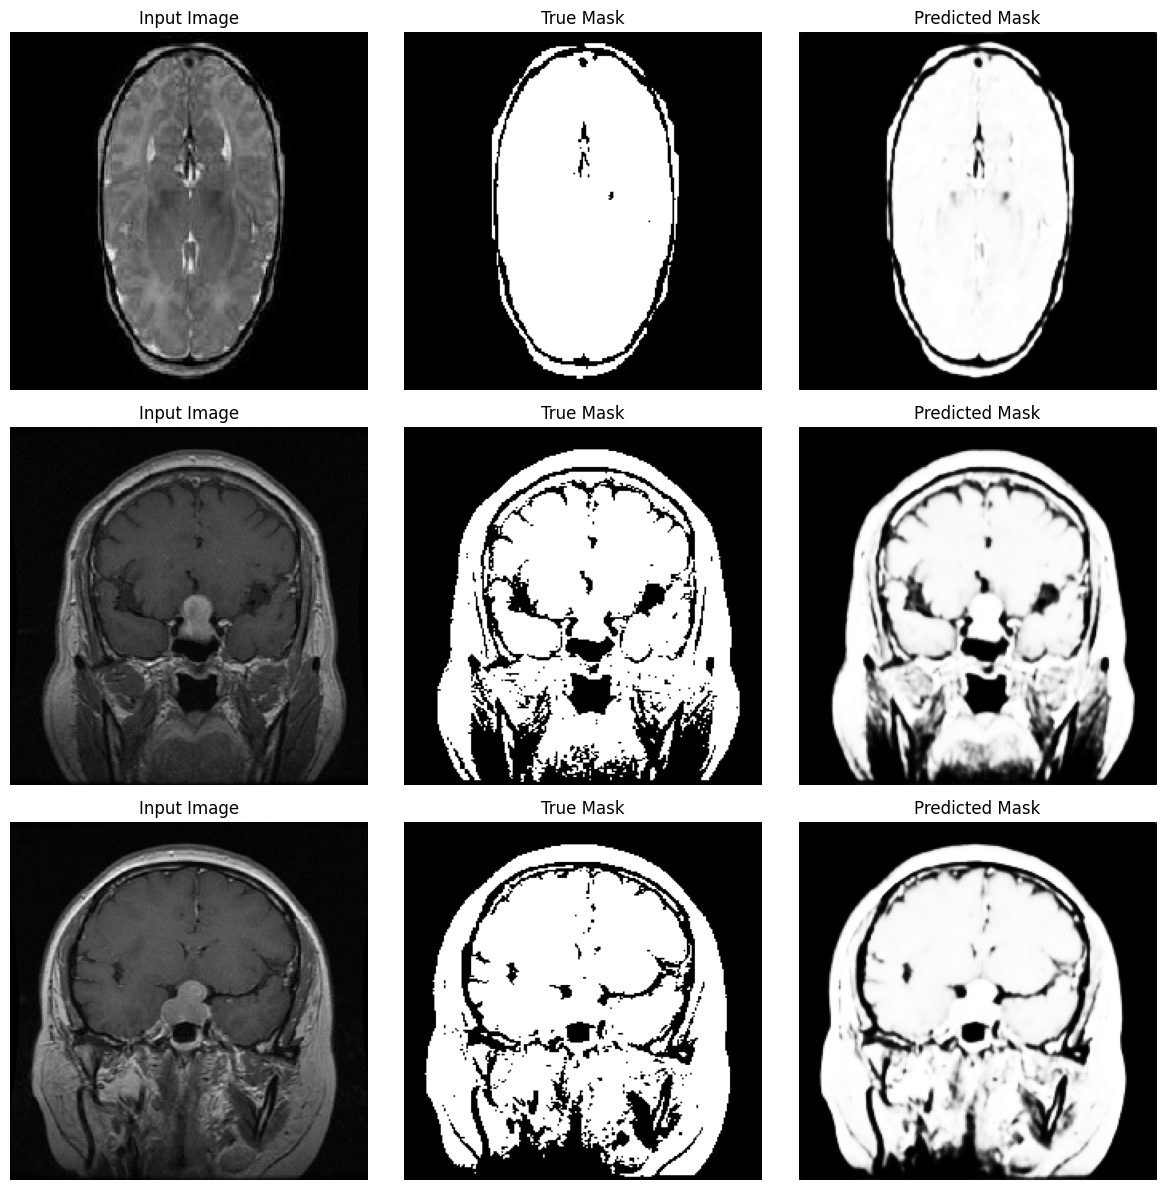

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 311ms/step - accuracy: 0.7015 - loss: 0.6343 - val_accuracy: 0.9172 - val_loss: 0.3670
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 353ms/step - accuracy: 0.9163 - loss: 0.2571 - val_accuracy: 0.9175 - val_loss: 0.2054
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 304ms/step - accuracy: 0.9305 - loss: 0.1746 - val_accuracy: 0.9241 - val_loss: 0.1890
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 308ms/step - accuracy: 0.9294 - loss: 0.1791 - val_accuracy: 0.9333 - val_loss: 0.1720
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 304ms/step - accuracy: 0.9352 - loss: 0.1649 - val_accuracy: 0.9327 - val_loss: 0.1723
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 307ms/step - accuracy: 0.9403 - loss: 0.1530 - val_accuracy: 0.9397 - val_loss: 0.1641
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 309ms/step - accuracy: 0.9438 - loss: 0.1437 - val_accuracy: 0.9438 - val_loss: 0.1552
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 307ms/step - accuracy: 0.9462 - loss: 0

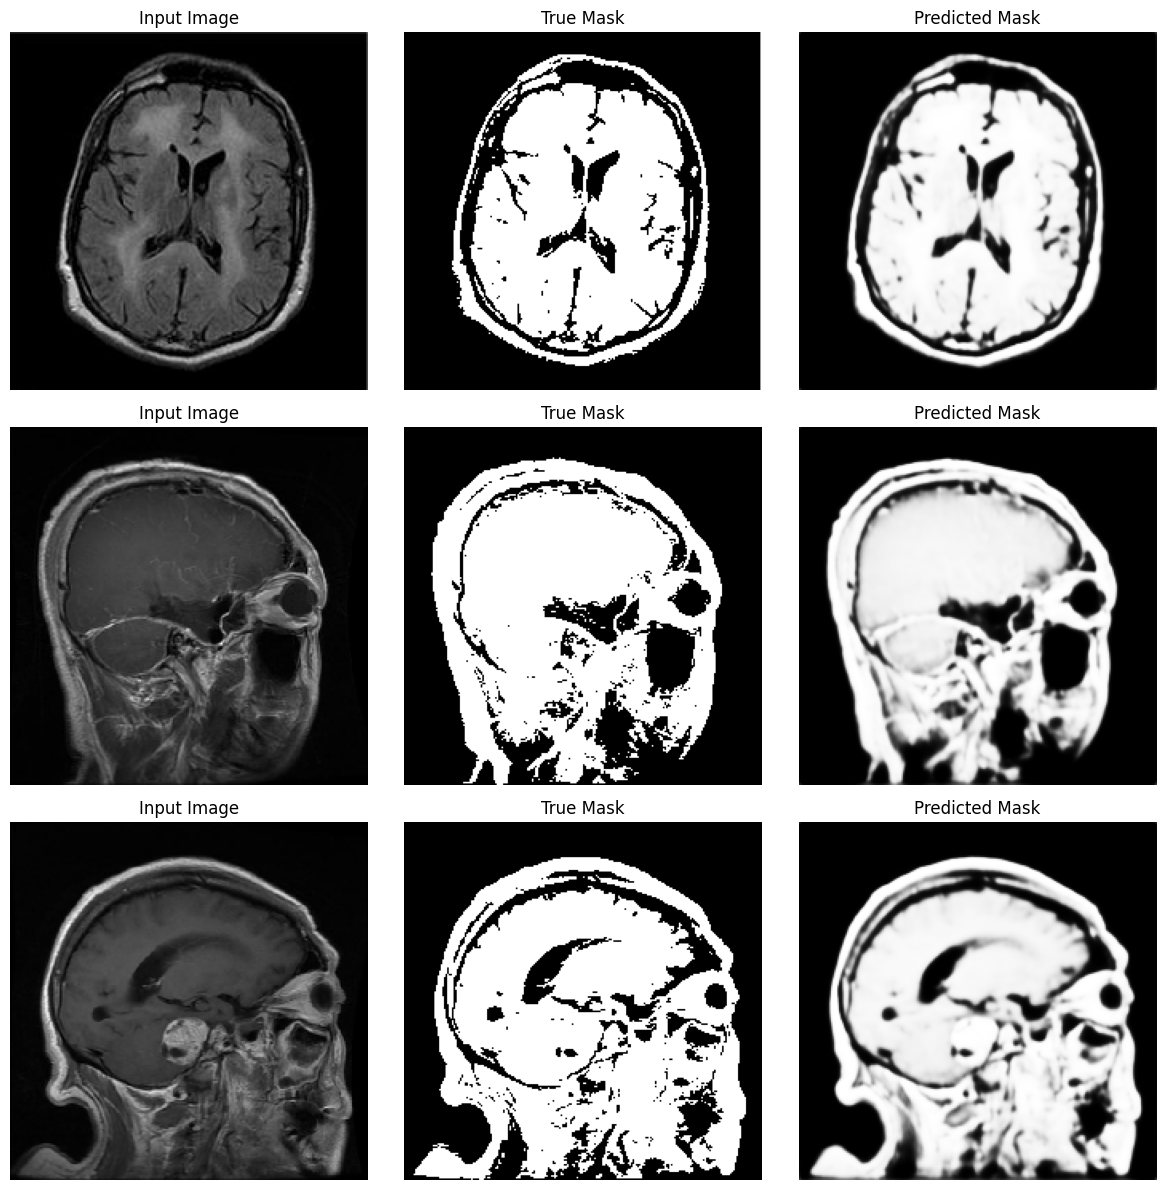

In [47]:
train_segmentation_generator = segmentation_generator(train_dataset)
val_segmentation_generator = segmentation_generator(test_dataset)

earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, restore_best_weights=True)

unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

history_unet = unet_model.fit(
    train_segmentation_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_steps=100,
    validation_data=val_segmentation_generator,
    callbacks=[earlyStopping]
)

x_seg, y_seg = next(val_segmentation_generator)

pred_masks = unet_model.predict(x_seg)

n = 3

plt.figure(figsize=(12, 4 * n))

for i in range(n):
    plt.subplot(n, 3, i * 3 + 1)
    plt.imshow(x_seg[i])
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(n, 3, i * 3 + 2)
    plt.imshow(y_seg[i].squeeze(), cmap="gray")
    plt.title("True Mask")
    plt.axis("off")

    plt.subplot(n, 3, i * 3 + 3)
    plt.imshow(pred_masks[i].squeeze(), cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


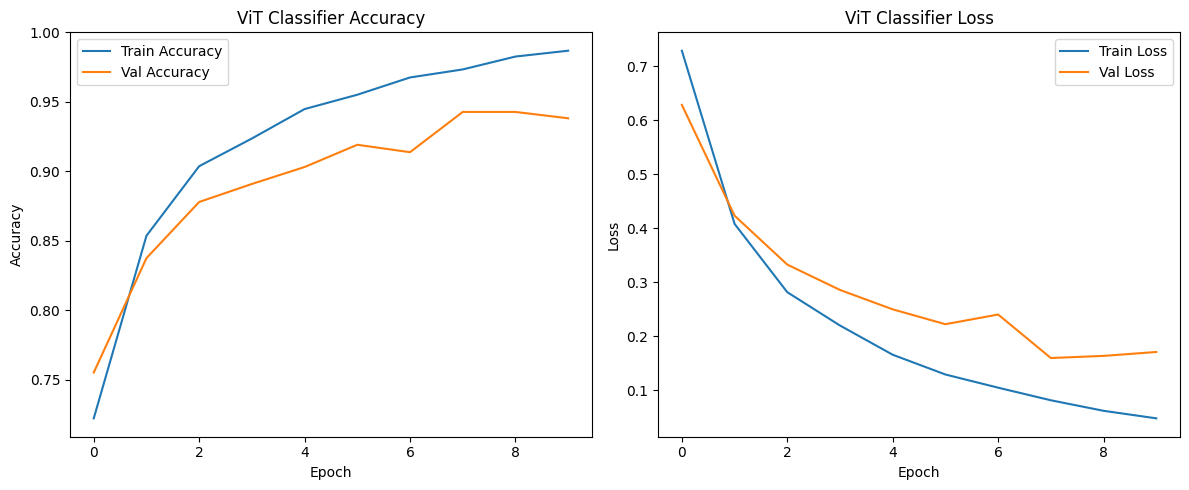

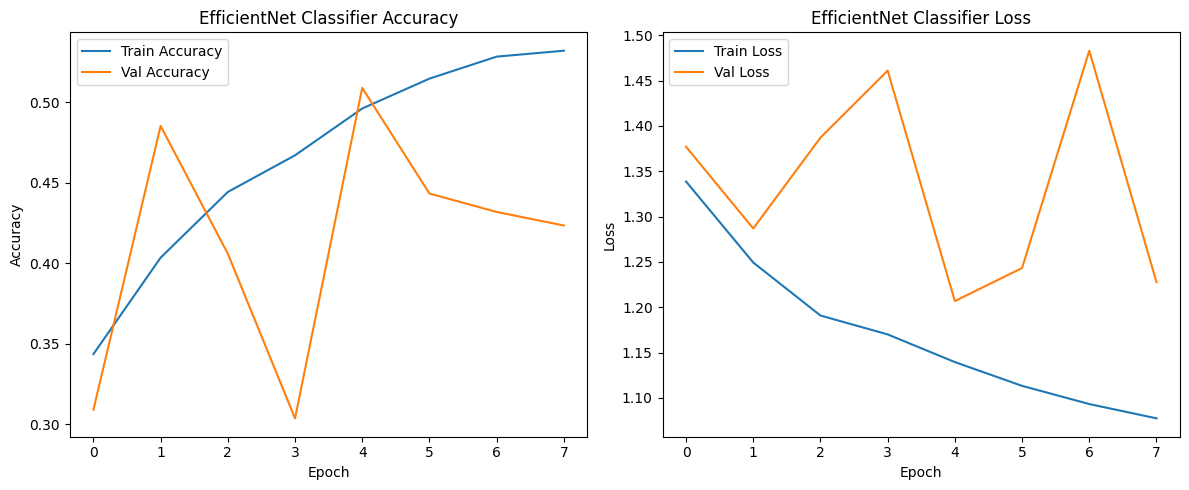

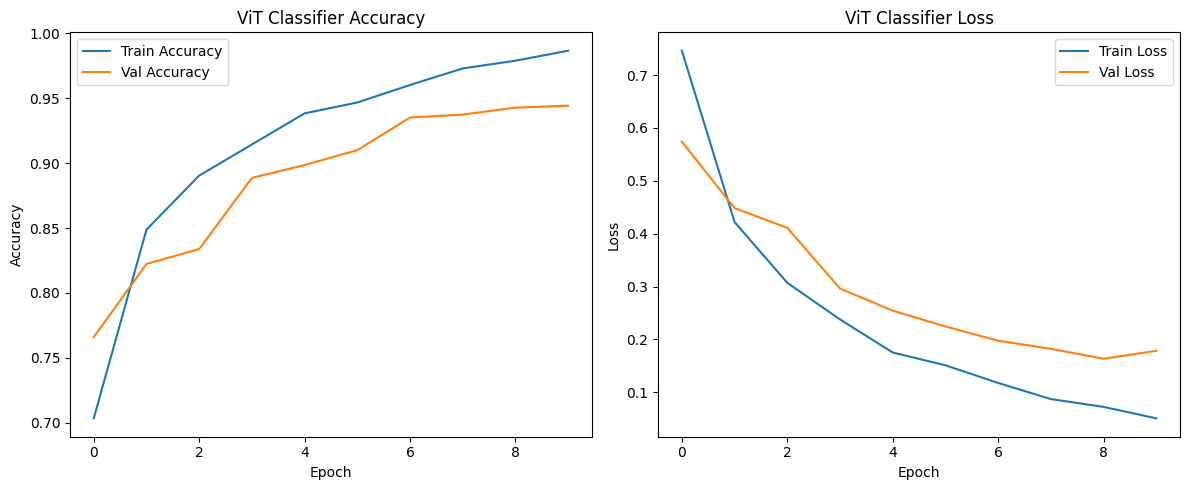

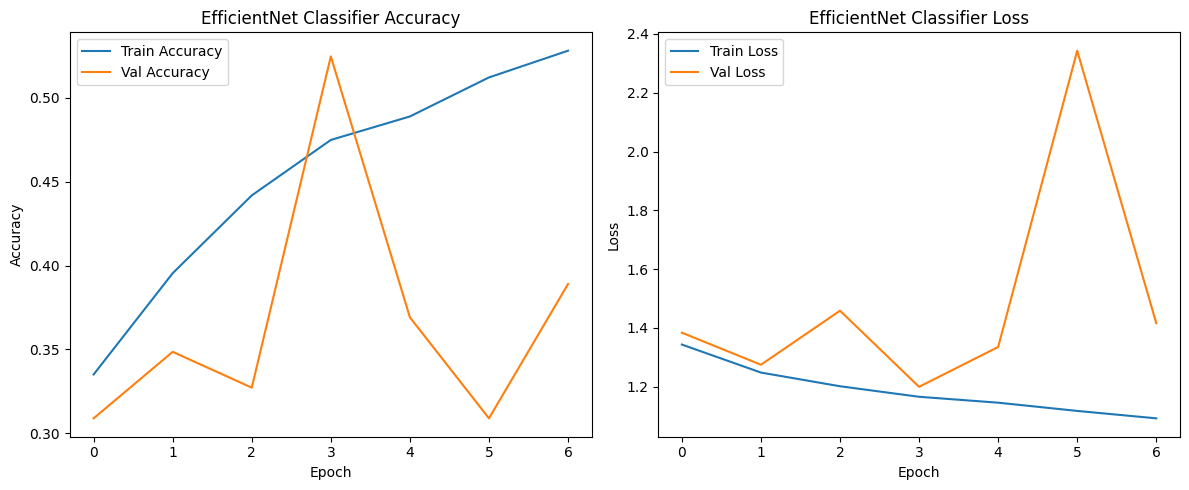

In [48]:
def plot_history(history, title_prefix="Model"):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f"{title_prefix} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{title_prefix} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_vit, title_prefix="ViT Classifier")

plot_history(history_eff, title_prefix="EfficientNet Classifier")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


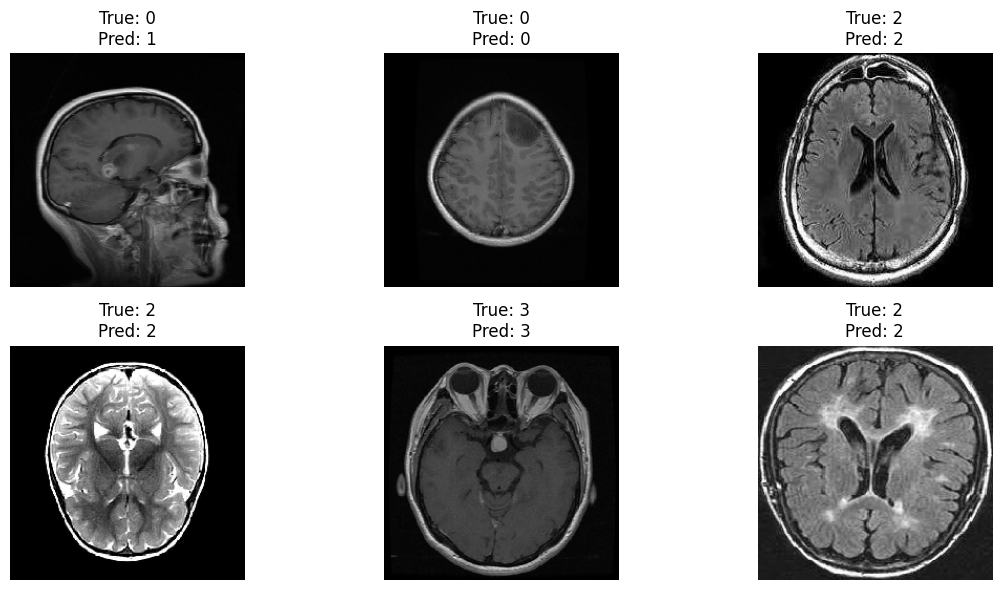

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


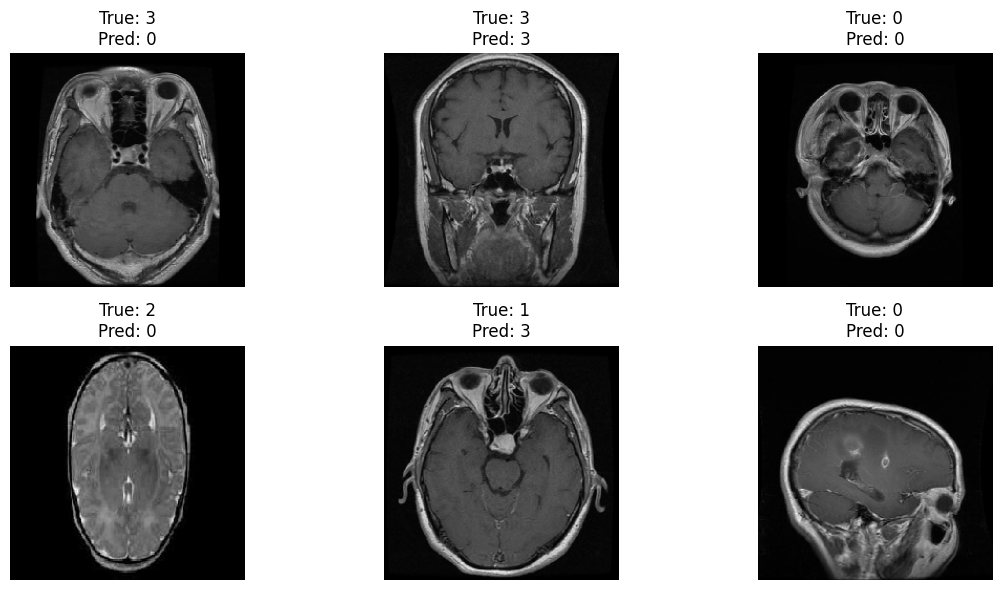

In [49]:
x_test, y_test = next(test_dataset)

preds_eff = eff_model.predict(x_test)

plt.figure(figsize=(12, 6))

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_test[i])
    plt.title(f"True: {np.argmax(y_test[i])}\nPred: {np.argmax(preds_eff[i])}")
    plt.axis("off")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


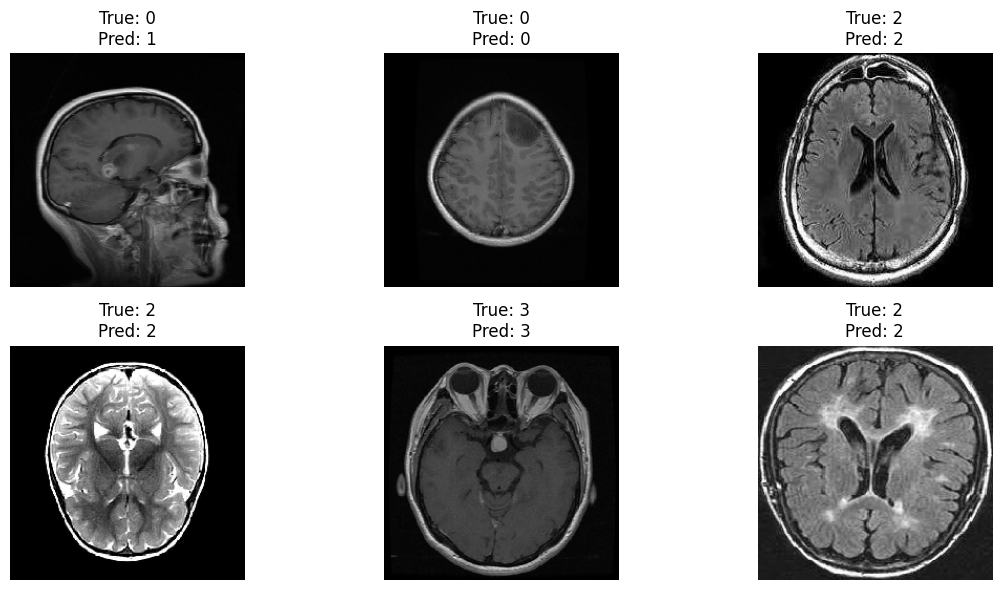

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


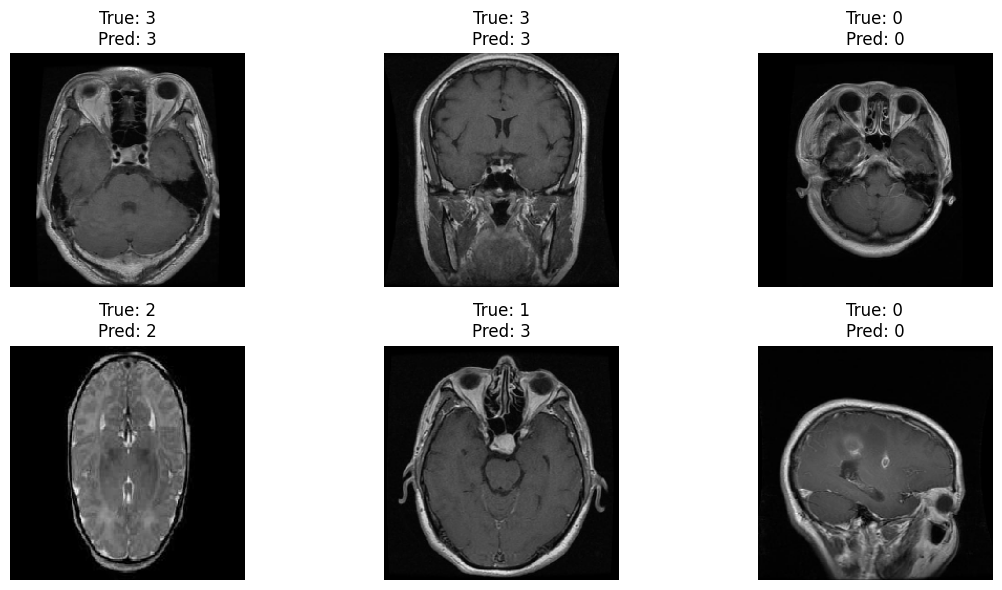

In [50]:
preds_vit = vit_model.predict(x_test)
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_test[i])
    plt.title(f"True: {np.argmax(y_test[i])}\nPred: {np.argmax(preds_vit[i])}")
    plt.axis("off")
plt.tight_layout()
plt.show()